In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter
import preprocessor as p
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


## Params

In [2]:
tweets_dir = os.path.join('./data/tweets')
max_results = 1000

In [3]:
def company2file(company_name):
    company_name = company_name.lower()
    return "".join([c for c in company_name if c.isalpha() or c.isdigit() or c==' ']).rstrip()

In [4]:
# Obtain company metadata
company_meta = pd.read_csv('./data/ipos-2021.csv')
company_meta.head()

,Name,Symbol,IPO Date,IPO Price,total shares outstanding,trading volume on listing day,(IPO +7) Date,New Avg Price After 1 Week,Exchange,HQ Location,Industry
0,Games &amp; Esports Experience Acquisition,GEEX,02-12-21,NaN,NaN,NaN,09-12-21,NaN,NaN,NaN,NaN
1,UTA Acquisition,UTAA,02-12-21,NaN,NaN,NaN,09-12-21,NaN,NaN,NaN,NaN
2,ROC Energy Acquisition,ROC,02-12-21,NaN,NaN,NaN,09-12-21,NaN,NaN,NaN,NaN
3,Capitalworks Emerging Markets Acquisition,CMCA,01-12-21,NaN,NaN,NaN,08-12-21,NaN,NaN,NaN,NaN
4,TLGY Acquisition,TLGY,01-12-21,NaN,NaN,NaN,08-12-21,NaN,NaN,NaN,NaN


In [5]:
pbar = tqdm(total=company_meta.shape[0])

tweets_per_company = []
try:
    for ipo_date, ticker, company in company_meta[[
        'IPO Date',
        'Symbol',
        'Name',
    ]].values:
        pbar.set_description(f"Cumulative Tweets: {sum(tweets_per_company)}; Company: {company}")
        out_csv = os.path.join(tweets_dir, str(ticker)+'.csv')

        # caching
        if os.path.isfile(out_csv):
            tweets_per_company.append(pd.read_csv(out_csv).shape[0])
            pbar.update(1)
            continue

        # date stuff
        ipo_date = pd.to_datetime(ipo_date).date()
        week_before = ipo_date - pd.to_timedelta(14, unit='d')

        # get tweets
        tweets_list = []
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'{company} OR {ticker} since:{week_before} until:{ipo_date} lang:en').get_items()):
            if i >= max_results:
                break

            tweets_list.append([
                tweet.date, 
                p.clean(tweet.content), 
                tweet.replyCount,
                tweet.retweetCount,
                tweet.likeCount,
                tweet.quoteCount,
                ])

        tweets_df = pd.DataFrame(tweets_list, columns=[
            'date', 
            'content', 
            'replyCount', 
            'retweetCount', 
            'likeCount',
            'quoteCount',
        ])

        tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date
        tweets_df.to_csv(out_csv)
        tweets_per_company.append(tweets_df.shape[0])
        pbar.update(1)

except KeyboardInterrupt:
    print('Interrupted')
    pass

pbar.close()

Cumulative Tweets: 193125; Company: nan: 100%|██████████| 1330/1330 [00:05<00:00, 234.05it/s]


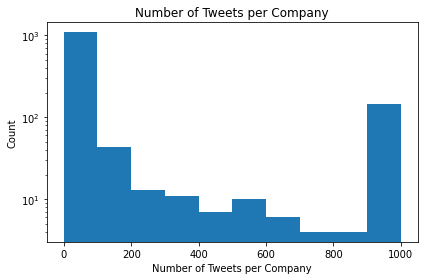

In [6]:
import matplotlib.pyplot as plt
plt.hist(tweets_per_company)
plt.title('Number of Tweets per Company')
plt.ylabel('Count')
plt.xlabel('Number of Tweets per Company')
plt.yscale('log')
plt.tight_layout()
plt.savefig('graphs/tweetcounts.jpg')
plt.show()

In [7]:
def get_sentiment(sentence):
    sentence = str(sentence)
    try:
        sentiment = analyzer.polarity_scores(str(sentence)['compound'])
    except:
        sentiment =  -100

    return sentiment

In [8]:
# Sentiment analysis
pbar = tqdm(total=company_meta.shape[0])
analyzer = SentimentIntensityAnalyzer()

sentiments = []
try:
    for ipo_date, ticker, company in company_meta[[
        'IPO Date',
        'Symbol',
        'Name',
    ]].values:
        # pbar.set_description(f"Company: {company}")
        out_csv = os.path.join(tweets_dir, str(ticker)+'.csv')

        tweets_df = pd.read_csv(out_csv, index_col=0)

        # caching
        if 'sentiment' in tweets_df.columns:
            sentiments.extend(tweets_df['sentiment'].values)
            pbar.update(1)
            continue

        # main
        tweets_df['sentiment'] = tweets_df['content'].apply(lambda sentence: analyzer.polarity_scores(str(sentence))['compound'])

        tweets_df.to_csv(out_csv)
        sentiments.extend(tweets_df['sentiment'].values)
        pbar.update(1)

except KeyboardInterrupt:
    print('Interrupted')
    pass

pbar.close()

100%|██████████| 1330/1330 [00:02<00:00, 504.44it/s]


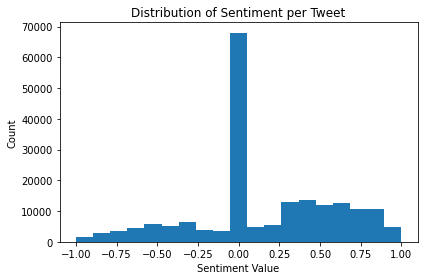

In [45]:
import matplotlib.pyplot as plt
plt.hist(sentiments, bins=np.linspace(-1, 1, 20))
plt.title('Distribution of Sentiment per Tweet')
plt.ylabel('Count')
plt.xlabel('Sentiment Value')
# plt.yscale('log')
plt.tight_layout()
plt.savefig('graphs/sentiments_tweets.jpg')
plt.show()

In [46]:
# Sentiment analysis
pbar = tqdm(total=company_meta.shape[0])

rows_arr = []
out_cols = ['Symbol', 'tweetCount', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'weightedSentiment', 'unweightedSentiment']
try:
    for ipo_date, ticker, company in company_meta[[
        'IPO Date',
        'Symbol',
        'Name',
    ]].values:
        # pbar.set_description(f"Company: {company}")
        out_csv = os.path.join(tweets_dir, str(ticker)+'.csv')

        tweets_df = pd.read_csv(out_csv, index_col=0)

        # get weighted average for sentiment
        weights = tweets_df[['replyCount', 'likeCount', 'retweetCount', 'quoteCount']].sum(axis=1)
        if sum(weights) == 0:
            mean_sentiment = np.mean(tweets_df["sentiment"])
        else:
            mean_sentiment = np.average(tweets_df['sentiment'], weights=weights)

        row_entry = [
            ticker, 
            tweets_df.shape[0],
            np.mean(tweets_df['replyCount']),
            np.mean(tweets_df['retweetCount']),
            np.mean(tweets_df['likeCount']),
            np.mean(tweets_df['quoteCount']),
            mean_sentiment,
            np.mean(tweets_df["sentiment"])
        ]

        rows_arr.append(row_entry)
        pbar.update(1)

except KeyboardInterrupt:
    print('Interrupted')
    pass

final_df = pd.DataFrame(
    rows_arr,
    columns=out_cols
)
final_df.to_csv('./data/company_tweets.csv')

pbar.close()
final_df.head()

100%|██████████| 1330/1330 [00:04<00:00, 285.41it/s]


,Symbol,tweetCount,replyCount,retweetCount,likeCount,quoteCount,weightedSentiment,unweightedSentiment
0,GEEX,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,UTAA,4,0.000000,0.000000,0.250000,0.000000,0.680800,0.482775
2,ROC,81,0.296296,0.185185,3.135802,0.012346,0.459609,0.349453
3,CMCA,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TLGY,1,0.000000,0.000000,0.000000,0.000000,0.610300,0.610300


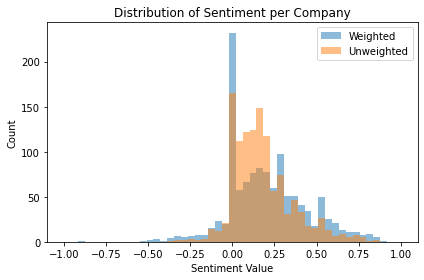

In [62]:
plt.hist(final_df.weightedSentiment, bins=np.linspace(-1, 1, 50),  alpha=0.5, label='Weighted')
plt.hist(final_df.unweightedSentiment, bins=np.linspace(-1, 1, 50),  alpha=0.5, label='Unweighted')
plt.title('Distribution of Sentiment per Company')
plt.ylabel('Count')
plt.xlabel('Sentiment Value')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('graphs/sentiments_company.jpg')
plt.show()

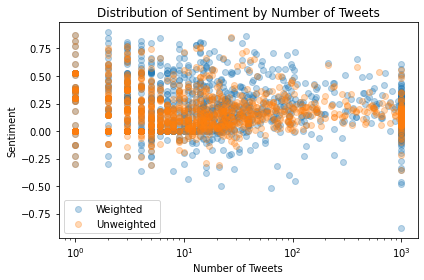

In [61]:
plt.scatter(y='weightedSentiment', x='tweetCount', data=final_df,  alpha=0.3, label='Weighted')
plt.scatter(y='unweightedSentiment', x='tweetCount', data=final_df,  alpha=0.3, label='Unweighted')
plt.title('Distribution of Sentiment by Number of Tweets')
plt.ylabel('Sentiment')
plt.xlabel('Number of Tweets')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('graphs/sentiments_by_numtweets.jpg')
plt.show()